In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification/garbage_classification'

# Function to load and preprocess the dataset
def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            resized_image = cv2.resize(image, target_shape[:2])
            filenames.append(resized_image)
            labels.append(i)

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y

# Define the target shape for resizing images
target_shape = (110, 110, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

Shape of X_train, y_train: (11170, 110, 110, 3) (11170, 12)
Shape of X_test, y_test: (3103, 110, 110, 3) (3103, 12)
Shape of X_val, y_val: (1242, 110, 110, 3) (1242, 12)


In [3]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

# Define the model architecture
MainInput = Input(shape=target_shape)
dn169 = VGG19(weights='imagenet', include_top=False, input_shape=target_shape, pooling='avg')(MainInput)
reshape = Reshape((16, 16, 2))(dn169)

conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)

conv = MaxPooling2D(strides=(2, 2), padding="same")(conv)

conv = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)
conv = Conv2D(filters=256, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = ChannelAttention()(conv)

conv = MaxPooling2D(pool_size=(2, 2), padding="same")(conv)

conv = Flatten()(conv)
conv = Dense(1024, activation="relu")(conv)
conv = Dense(512, activation="relu")(conv)
conv = Dense(y_train.shape[1], activation="softmax")(conv)

model_dn169 = Model(inputs=MainInput, outputs=conv)
model_dn169.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 reshape (Reshape)           (None, 16, 16, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       12672     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 channel_attention (ChannelA  (None, 16, 16, 128)      2184   

In [4]:
# Compile the model
model_dn169.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])

# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model_dn169.fit(X_train, y_train,
                          epochs=30,
                          batch_size=12,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

Epoch 1/30
931/931 [==============================] - 79s 71ms/step - loss: 1.0925 - accuracy: 0.6575 - val_loss: 0.6070 - val_accuracy: 0.8003
Epoch 2/30
931/931 [==============================] - 60s 64ms/step - loss: 0.5891 - accuracy: 0.8161 - val_loss: 0.5113 - val_accuracy: 0.8374
Epoch 3/30
931/931 [==============================] - 59s 64ms/step - loss: 0.4230 - accuracy: 0.8676 - val_loss: 0.5174 - val_accuracy: 0.8341
Epoch 4/30
931/931 [==============================] - 59s 63ms/step - loss: 0.3224 - accuracy: 0.8971 - val_loss: 0.5484 - val_accuracy: 0.8366
Epoch 5/30
931/931 [==============================] - 59s 64ms/step - loss: 0.2611 - accuracy: 0.9174 - val_loss: 0.5115 - val_accuracy: 0.8599
Epoch 6/30
931/931 [==============================] - 60s 64ms/step - loss: 0.2072 - accuracy: 0.9362 - val_loss: 0.3806 - val_accuracy: 0.8953
Epoch 7/30
931/931 [==============================] - 60s 64ms/step - loss: 0.1778 - accuracy: 0.9440 - val_loss: 0.3883 - val_accuracy:

Number of epochs trained: 30


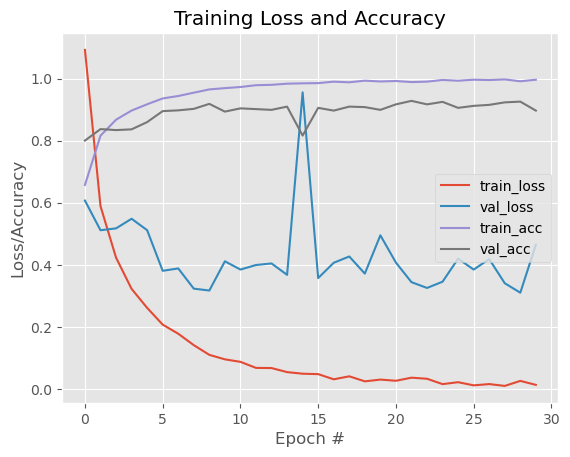

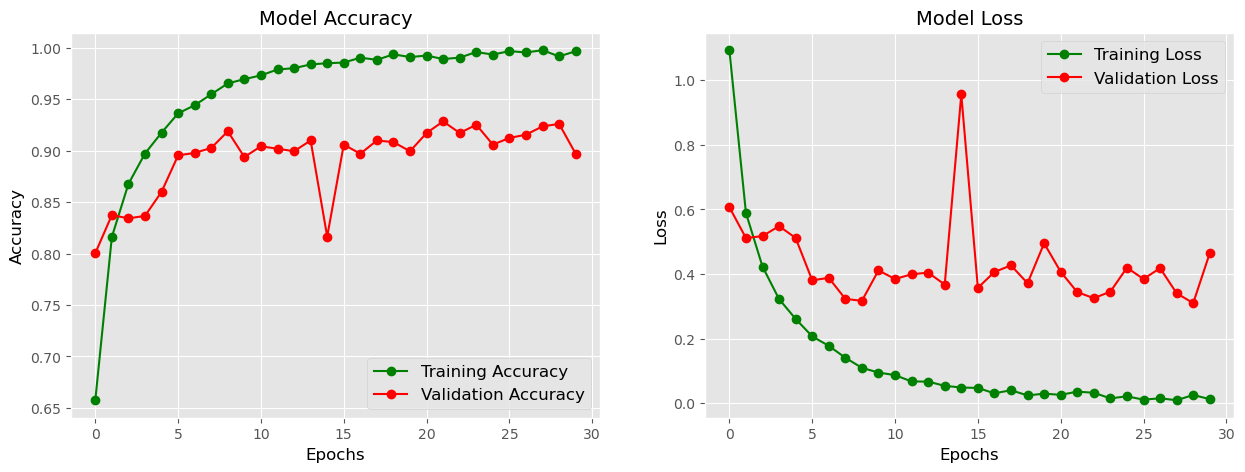

In [5]:
# Load the best weights
model_dn169.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("DenseNet169_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# History plotting
epochs = [i for i in range(num_epochs_trained)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname': 'Times New Roman', 'size': '12', 'color': 'black', 'weight': 'normal'}
ax[0].set_xlabel("Epochs", fontdict=label_font)
ax[0].set_ylabel("Accuracy", fontdict=label_font)

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)

plt.show()

In [6]:
# Evaluate the model on the test set
val_loss, val_accuracy = model_dn169.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)




Test loss: 0.32648125290870667
Test accuracy: 0.9291008710861206


In [7]:
# Make predictions on the test set
y_pred = model_dn169.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_folders = os.listdir(train_path)
class_names = class_folders
report = classification_report(y_test_labels, y_pred, target_names=class_names)
print(report)


97/97 [==============================] - 5s 37ms/step
              precision    recall  f1-score   support

       metal       0.79      0.84      0.82       159
 white-glass       0.87      0.83      0.85       147
  biological       0.89      0.97      0.93       196
       paper       0.84      0.96      0.89       204
 brown-glass       0.97      0.84      0.90       135
     battery       0.95      0.94      0.94       188
       trash       0.90      0.94      0.92       142
   cardboard       0.97      0.89      0.93       186
       shoes       0.93      0.94      0.94       394
     clothes       0.99      0.97      0.98      1076
     plastic       0.81      0.78      0.80       157
 green-glass       0.95      0.93      0.94       119

    accuracy                           0.93      3103
   macro avg       0.91      0.90      0.90      3103
weighted avg       0.93      0.93      0.93      3103

